# Music Recommendation System

A content-based music recommendation system that suggests similar songs based on lyrics similarity using TF-IDF vectorization and FAISS (Facebook AI Similarity Search) for efficient nearest neighbor search.

---

## Table of Contents

1. [Environment Setup](#1-environment-setup)
2. [Import Libraries](#2-import-libraries)
3. [Data Collection](#3-data-collection)
4. [Data Exploration & Understanding](#4-data-exploration--understanding)
5. [Data Preprocessing](#5-data-preprocessing)
6. [Feature Engineering (TF-IDF)](#6-feature-engineering-tf-idf)
7. [Building FAISS Index](#7-building-faiss-index)
8. [Recommendation Function](#8-recommendation-function)
9. [Model Persistence](#9-model-persistence)

### 🚀 Improvements
10. [Improvement 1: Word2Vec / FastText for Semantic Similarity](#-improvement-1-word2vec--fasttext-for-semantic-similarity)
11. [Improvement 2: Sentence-BERT for Semantic Similarity](#-improvement-2-sentence-bert-for-semantic-similarity)
12. [Improvement 3: Audio Features from Spotify API](#-improvement-3-audio-features-from-spotify-api)

---

## 1. Environment Setup

First, we need to install all the required libraries for this project:

- **faiss-cpu**: Facebook AI Similarity Search for efficient similarity search
- **kaggle**: API to download datasets from Kaggle
- **numpy & pandas**: Data manipulation and numerical operations
- **matplotlib**: Data visualization
- **scikit-learn**: Machine learning utilities (TF-IDF, normalization)
- **wordcloud**: Visualizing word frequencies
- **nltk**: Natural Language Toolkit for text preprocessing


In [2]:
%pip install faiss-cpu kaggle numpy pandas matplotlib scikit-learn wordcloud nltk gensim tqdm -q

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

Importing all necessary libraries for:
- **File & Data Operations**: `os`, `json`, `numpy`, `pandas`
- **Text Processing**: `re`, `nltk` (stopwords, tokenization)
- **Machine Learning**: `sklearn` (TF-IDF, cosine similarity, normalization)
- **Visualization**: `matplotlib`, `wordcloud`
- **Vector Search**: `faiss` for efficient similarity search
- **Model Persistence**: `joblib` for saving/loading models

In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import normalize
import faiss
import pickle
from scipy.sparse import save_npz
import gensim.downloader as api
from gensim.models import Word2Vec, FastText

KeyboardInterrupt: 

## 3. Data Collection

We're using the **Spotify Million Song Dataset** from Kaggle, which contains song lyrics along with artist and song information.

### 3.1 Configure Kaggle API

Load Kaggle credentials from `kaggle.json` file. You need to:
1. Create a Kaggle account
2. Go to Settings → API → Create New Token
3. Save the downloaded `kaggle.json` file in the project root

In [ ]:
kaggle_config = json.load(open('kaggle.json'))
kaggle_config.keys()

dict_keys(['username', 'key'])

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

### 3.2 Download Dataset

Download the Spotify Million Song Dataset using Kaggle CLI. The dataset will be saved to the `./data` directory.


In [ ]:
!kaggle datasets download notshrirang/spotify-million-song-dataset -p ./data --unzip

^C


Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0




  0%|          | 0.00/20.7M [00:00<?, ?B/s]
100%|██████████| 20.7M/20.7M [00:00<00:00, 1.55GB/s]


### 3.3 Load Dataset

Load the downloaded CSV file into a pandas DataFrame for exploration and processing.

In [ ]:
df = pd.read_csv('./data/spotify_millsongdata.csv')
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


## 4. Data Exploration & Understanding

Let's explore the dataset to understand its structure, size, and content quality.

### 4.1 Dataset Overview

Check the shape, data types, and basic statistics of our dataset.

In [ ]:
print("Data shape: ", df.shape)
print("\nData info:")
df.info()

Data shape:  (57650, 4)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


### 4.2 Missing Values Check

Check for any missing values in the dataset that might need handling.

In [ ]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

### 4.3 Top Artists Analysis

Identify the most frequently appearing artists in the dataset.

In [ ]:
top_artists = df['artist'].value_counts().head(10)
print("Top 10 Artists:\n", top_artists)

Top 10 Artists:
 artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


### 4.4 Lyrics Word Cloud

Visualize the most common words in all song lyrics using a word cloud. This helps us understand the common themes and vocabulary in the dataset.

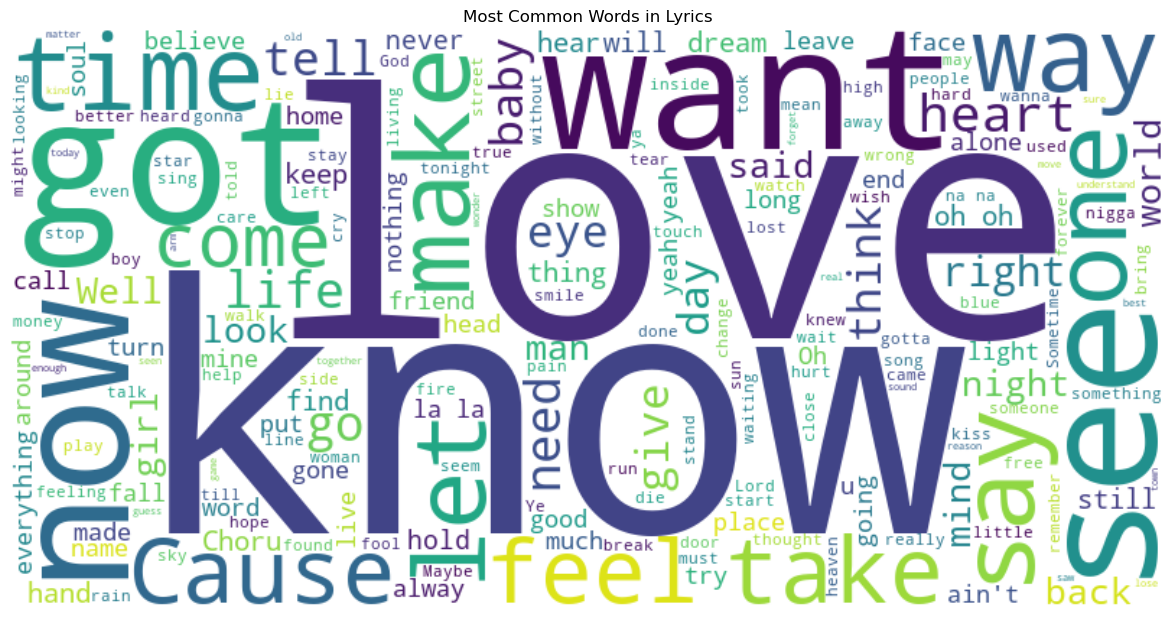

In [ ]:
all_lyrics = ' '.join(df['text'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Lyrics')
plt.show()

## 5. Data Preprocessing

Text preprocessing is crucial for building an effective recommendation system. We need to clean and normalize the lyrics text.

### 5.1 Download NLTK Resources

Download the required NLTK data packages:
- **punkt**: Tokenizer models for splitting text into words
- **stopwords**: Common words (like "the", "is", "at") that we'll remove

In [ ]:
nltk.download('punkt')
nltk.download('stopwords') 
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 5.2 Define Stopwords

Load the English stopwords list. These are common words that don't carry significant meaning for similarity comparison.

In [ ]:
stop_words = set(stopwords.words('english'))

### 5.3 Text Preprocessing Function

Create a function to clean and normalize text:
1. **Remove special characters**: Keep only letters and spaces
2. **Convert to lowercase**: Normalize case
3. **Tokenize**: Split text into individual words
4. **Remove stopwords**: Filter out common words

In [ ]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

### 5.4 Apply Preprocessing

Apply the preprocessing function to all song lyrics. This creates a new `cleaned_text` column with the processed lyrics.

In [ ]:
df['cleaned_text'] = df['text'].apply(preprocess_text)
df[['text', 'cleaned_text']].head()

,text,cleaned_text
0,"Look at her face, it's a wonderful face \r\nA...",look face wonderful face means something speci...
1,"Take it easy with me, please \r\nTouch me gen...",take easy please touch gently like summer even...
2,I'll never know why I had to go \r\nWhy I had...,ill never know go put lousy rotten show boy to...
3,Making somebody happy is a question of give an...,making somebody happy question give take learn...
4,Making somebody happy is a question of give an...,making somebody happy question give take learn...


## 6. Feature Engineering (TF-IDF)

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical statistic that reflects how important a word is to a document in a collection.

- **Term Frequency (TF)**: How often a word appears in a document
- **Inverse Document Frequency (IDF)**: How rare a word is across all documents

Words that appear frequently in one song but rarely across all songs get higher weights, making them better for distinguishing between songs.

We limit to `max_features=5000` to keep the most important terms and reduce dimensionality.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, dtype=np.float32)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Vocabulary Size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF Matrix Shape: (57650, 5000)
Vocabulary Size: 5000


## 7. Building FAISS Index

**FAISS (Facebook AI Similarity Search)** is a library for efficient similarity search and clustering of dense vectors.

### Why FAISS?
- Traditional cosine similarity has O(n) complexity for each query
- FAISS uses optimized algorithms for faster nearest neighbor search
- Essential for scaling to large datasets (millions of songs)

### Index Type: `IndexFlatIP`
- **IP** = Inner Product (equivalent to cosine similarity for L2-normalized vectors)
- **Flat** = Exact search (no approximation)
- We normalize vectors with L2 norm so inner product equals cosine similarity

In [ ]:
X = tfidf_matrix.toarray()
X = normalize(X, norm="l2")

dim = X.shape[1]
print(f"Vector Dimension: {dim}")

index = faiss.IndexFlatIP(dim)
index.add(X)

print(f"Total vectors in FAISS index: {index.ntotal}")
print("FAISS index built successfully!")

Vector Dimension: 5000
Total vectors in FAISS index: 57650
FAISS index built successfully!


In [ ]:
def recommend_songs(song_name, df=df, top_k=5):

    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]

    query = X[idx].reshape(1, -1)

    scores, indices = index.search(query, top_k + 1)

    return df[['song', 'artist']].iloc[indices[0][1:]]

## 🚀 Improvement 1: Word2Vec / FastText for Semantic Similarity

**Limitation of TF-IDF:**
- TF-IDF treats words as independent tokens (bag-of-words approach)
- Cannot capture semantic relationships between words
- "happy" and "joyful" are completely different features in TF-IDF

**Solution: Word Embeddings (Word2Vec/FastText)**
- Words are represented as dense vectors in a continuous vector space
- Semantically similar words have similar vectors
- Can capture analogies: king - man + woman ≈ queen

### Comparison:
| Method | Pros | Cons |
|--------|------|------|
| **TF-IDF** | Fast, interpretable | No semantic understanding |
| **Word2Vec** | Captures semantics, pre-trained available | OOV words are ignored |
| **FastText** | Handles OOV via subwords | Slightly slower than Word2Vec |


### 7.1 Prepare Tokenized Lyrics for Word Embeddings

We need to tokenize lyrics into lists of words for training/using word embedding models.


In [ ]:
# Tokenize cleaned lyrics into list of words
df['tokens'] = df['cleaned_text'].apply(lambda x: x.split())

# View sample tokenized lyrics
print("Sample tokenized lyrics:")
print(df['tokens'].iloc[0][:20])  # First 20 tokens of first song
print(f"\nTotal songs: {len(df)}")
print(f"Average tokens per song: {df['tokens'].apply(len).mean():.1f}")


Sample tokenized lyrics:
['look', 'face', 'wonderful', 'face', 'means', 'something', 'special', 'look', 'way', 'smiles', 'sees', 'lucky', 'one', 'fellow', 'shes', 'kind', 'girl', 'makes', 'feel', 'fine']

Total songs: 57650
Average tokens per song: 116.7


### 7.2 Option A: Using Pre-trained Word2Vec (Google News)

Using pre-trained Word2Vec model trained on Google News (3 million words, 300-dimensional vectors).

**Pros:** 
- High-quality embeddings trained on massive corpus
- Captures general semantic relationships

**Cons:**
- Large download (~1.5GB)
- May miss domain-specific music vocabulary


In [ ]:
# Download and load pre-trained Word2Vec model (Google News 300d)
# This may take a while on first run (~1.5GB download)
print("Loading pre-trained Word2Vec model (Google News 300d)...")
print("This may take a few minutes on first run...")

try:
    w2v_model = api.load('word2vec-google-news-300')
    print(f"✅ Model loaded successfully!")
    print(f"Vocabulary size: {len(w2v_model.key_to_index):,}")
    print(f"Vector dimension: {w2v_model.vector_size}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Falling back to training custom model...")


Loading pre-trained Word2Vec model (Google News 300d)...
This may take a few minutes on first run...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
✅ Model loaded successfully!
Vocabulary size: 3,000,000
Vector dimension: 300


### 7.3 Document Embedding Function

To get a single vector representation for an entire song (document), we compute the **weighted average** of word vectors:

$$\vec{d} = \frac{1}{|W|} \sum_{w \in W} \vec{w}$$

where $W$ is the set of words in the document and $\vec{w}$ is the word vector.


In [ ]:
def get_document_embedding(tokens, model, vector_size=300):
    """
    Compute document embedding by averaging word vectors.
    
    Args:
        tokens: List of words in the document
        model: Word2Vec/FastText model
        vector_size: Dimension of word vectors
    
    Returns:
        numpy array of shape (vector_size,) - document embedding
    """
    # Get vectors for words that exist in the model's vocabulary
    word_vectors = []
    for word in tokens:
        try:
            word_vectors.append(model[word])
        except KeyError:
            # Word not in vocabulary - skip it
            continue
    
    if len(word_vectors) == 0:
        # If no words found, return zero vector
        return np.zeros(vector_size)
    
    # Return mean of all word vectors
    return np.mean(word_vectors, axis=0)


# Test the function
sample_tokens = df['tokens'].iloc[0]
sample_embedding = get_document_embedding(sample_tokens, w2v_model)
print(f"Sample document embedding shape: {sample_embedding.shape}")
print(f"First 10 values: {sample_embedding[:10]}")


Sample document embedding shape: (300,)
First 10 values: [ 0.03464193  0.01799033  0.04964281  0.09320665 -0.0741931  -0.0054287
  0.05288998 -0.10220951  0.0597229   0.04583878]


### 7.4 Build Document Embeddings for All Songs

Now we compute embeddings for all songs in our dataset.


In [ ]:
from tqdm import tqdm

print("Computing document embeddings for all songs...")
print("This may take a few minutes...")

# Compute embeddings for all songs
doc_embeddings_w2v = []
for tokens in tqdm(df['tokens'], desc="Processing songs"):
    embedding = get_document_embedding(tokens, w2v_model, vector_size=300)
    doc_embeddings_w2v.append(embedding)

# Convert to numpy array
X_w2v = np.array(doc_embeddings_w2v, dtype=np.float32)

print(f"\n✅ Document embeddings shape: {X_w2v.shape}")
print(f"Memory usage: {X_w2v.nbytes / 1024 / 1024:.2f} MB")


Computing document embeddings for all songs...
This may take a few minutes...


Processing songs: 100%|██████████| 57650/57650 [00:32<00:00, 1789.81it/s]


✅ Document embeddings shape: (57650, 300)
Memory usage: 65.98 MB


### 7.5 Option B: Train Custom FastText Model

FastText extends Word2Vec by representing words as bags of character n-grams. This allows it to:
- Handle **out-of-vocabulary (OOV)** words by composing subword vectors
- Better handle **misspellings** and **slang** common in lyrics
- Capture **morphological** relationships (e.g., "love", "loving", "loved")

**Training Parameters:**
- `vector_size=100`: Dimension of word vectors (smaller for faster training)
- `window=5`: Context window size
- `min_count=2`: Ignore words that appear less than 2 times
- `epochs=10`: Number of training iterations
- `sg=1`: Use Skip-gram (better for small datasets)


In [ ]:
print("Training custom FastText model on lyrics corpus...")

# Train FastText model on our lyrics data
fasttext_model = FastText(
    sentences=df['tokens'].tolist(),
    vector_size=100,       # Embedding dimension
    window=5,              # Context window
    min_count=2,           # Minimum word frequency
    workers=4,             # Parallel workers
    sg=1,                  # Skip-gram model
    epochs=10              # Training epochs
)

print(f"✅ FastText model trained successfully!")
print(f"Vocabulary size: {len(fasttext_model.wv.key_to_index):,}")
print(f"Vector dimension: {fasttext_model.wv.vector_size}")


Training custom FastText model on lyrics corpus...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

✅ FastText model trained successfully!
Vocabulary size: 52,953
Vector dimension: 100


### 7.6 Explore Semantic Relationships

Let's verify that our FastText model captured meaningful semantic relationships.


In [ ]:
# Find words similar to common music-related terms
test_words = ['love', 'heart', 'dance', 'night', 'baby']

print("Words most similar to common lyrics terms:\n")
for word in test_words:
    try:
        similar = fasttext_model.wv.most_similar(word, topn=5)
        similar_words = [f"{w} ({s:.3f})" for w, s in similar]
        print(f"'{word}' → {', '.join(similar_words)}")
    except KeyError:
        print(f"'{word}' not in vocabulary")


Words most similar to common lyrics terms:

'love' → ohlove (0.774), itlove (0.759), mylove (0.749), alove (0.748), inlove (0.744)
'heart' → heartfelt (0.795), heartmy (0.792), heartheart (0.753), hearts (0.745), hearttheres (0.733)
'dance' → dancego (0.797), danceevery (0.755), decadance (0.728), dancefloor (0.712), dancins (0.706)
'night' → nightoh (0.807), nightynight (0.806), nightgo (0.785), nightnight (0.773), nightspot (0.772)
'baby' → ofbaby (0.799), bbaby (0.798), ohbaby (0.787), babyi (0.785), bbbbaby (0.780)


### 7.7 Build FastText Document Embeddings

Now let's create document embeddings using our trained FastText model.


In [ ]:
print("Computing FastText document embeddings for all songs...")

# Compute embeddings using FastText
doc_embeddings_ft = []
for tokens in tqdm(df['tokens'], desc="Processing songs"):
    embedding = get_document_embedding(tokens, fasttext_model.wv, vector_size=100)
    doc_embeddings_ft.append(embedding)

# Convert to numpy array
X_ft = np.array(doc_embeddings_ft, dtype=np.float32)

print(f"\n✅ FastText document embeddings shape: {X_ft.shape}")
print(f"Memory usage: {X_ft.nbytes / 1024 / 1024:.2f} MB")


Computing FastText document embeddings for all songs...


Processing songs: 100%|██████████| 57650/57650 [00:56<00:00, 1028.66it/s]


✅ FastText document embeddings shape: (57650, 100)
Memory usage: 21.99 MB


### 7.8 Build FAISS Indexes for Semantic Search

Create FAISS indexes for both Word2Vec and FastText embeddings.


In [ ]:
# Normalize embeddings for cosine similarity
X_w2v_norm = normalize(X_w2v, norm='l2')
X_ft_norm = normalize(X_ft, norm='l2')

# Build FAISS index for Word2Vec embeddings
print("Building FAISS index for Word2Vec embeddings...")
index_w2v = faiss.IndexFlatIP(X_w2v_norm.shape[1])
index_w2v.add(X_w2v_norm)
print(f"✅ Word2Vec FAISS index: {index_w2v.ntotal} vectors, {X_w2v_norm.shape[1]} dimensions")

# Build FAISS index for FastText embeddings
print("\nBuilding FAISS index for FastText embeddings...")
index_ft = faiss.IndexFlatIP(X_ft_norm.shape[1])
index_ft.add(X_ft_norm)
print(f"✅ FastText FAISS index: {index_ft.ntotal} vectors, {X_ft_norm.shape[1]} dimensions")


Building FAISS index for Word2Vec embeddings...
✅ Word2Vec FAISS index: 57650 vectors, 300 dimensions

Building FAISS index for FastText embeddings...
✅ FastText FAISS index: 57650 vectors, 100 dimensions


### 7.9 Semantic Recommendation Functions

Create recommendation functions using Word2Vec and FastText embeddings.


In [ ]:
def recommend_songs_w2v(song_name, df=df, top_k=5):
    """
    Recommend songs using Word2Vec embeddings.
    """
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]
    
    query = X_w2v_norm[idx].reshape(1, -1)
    scores, indices = index_w2v.search(query, top_k + 1)
    
    result = df[['song', 'artist']].iloc[indices[0][1:]].copy()
    result['similarity'] = scores[0][1:]
    return result


def recommend_songs_fasttext(song_name, df=df, top_k=5):
    """
    Recommend songs using FastText embeddings.
    """
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]
    
    query = X_ft_norm[idx].reshape(1, -1)
    scores, indices = index_ft.search(query, top_k + 1)
    
    result = df[['song', 'artist']].iloc[indices[0][1:]].copy()
    result['similarity'] = scores[0][1:]
    return result


### 7.10 Compare All Methods: TF-IDF vs Word2Vec vs FastText

Let's compare recommendations from all three approaches for the same song.


In [ ]:
# Test with a sample song
test_song = df['song'].iloc[0]
test_artist = df['artist'].iloc[0]

print(f"🎵 Recommendations for: '{test_song}' by {test_artist}")
print("=" * 70)

print("\n📊 TF-IDF Recommendations:")
print("-" * 40)
display(recommend_songs(test_song))

print("\n📊 Word2Vec Recommendations:")
print("-" * 40)
display(recommend_songs_w2v(test_song))

print("\n📊 FastText Recommendations:")
print("-" * 40)
display(recommend_songs_fasttext(test_song))


🎵 Recommendations for: 'Ahe's My Kind Of Girl' by ABBA

📊 TF-IDF Recommendations:
----------------------------------------


,song,artist
44380,The Kind Of Girl I Could Love,The Monkees
26374,Could I,Bread
40719,She's So European,Kiss
14018,One Of These Things First,Nick Drake
11857,That Boy,Lloyd Cole



📊 Word2Vec Recommendations:
----------------------------------------


,song,artist,similarity
14616,The Girl In The Dirty Shirt,Oasis,0.916836
28815,Fairytale Morning,David Allan Coe,0.914400
50137,Close,Rascal Flatts,0.911261
9142,Something In The Way She Moves,James Taylor,0.911046
54305,Suckerpath,Ugly Kid Joe,0.910800



📊 FastText Recommendations:
----------------------------------------


,song,artist,similarity
34,I Am Just A Girl,ABBA,0.957312
10011,Girlfriend,Justin Bieber,0.953971
44380,The Kind Of Girl I Could Love,The Monkees,0.953525
40676,Love Her All I Can,Kiss,0.952431
18182,No One Makes It On Her Own,Roxette,0.952158


### 7.11 Save Semantic Models

Save the trained models and embeddings for later use.


In [ ]:
# Save FastText model
fasttext_model.save("fasttext_lyrics.model")
print("✅ Saved: fasttext_lyrics.model")

# Save FastText embeddings
np.save("embeddings_fasttext.npy", X_ft)
print("✅ Saved: embeddings_fasttext.npy")

# Save Word2Vec embeddings (from pre-trained model)
np.save("embeddings_w2v.npy", X_w2v)
print("✅ Saved: embeddings_w2v.npy")

# Save FAISS indexes
faiss.write_index(index_w2v, "faiss_w2v.index")
print("✅ Saved: faiss_w2v.index")

faiss.write_index(index_ft, "faiss_fasttext.index")
print("✅ Saved: faiss_fasttext.index")

print("\n🎉 All semantic models saved successfully!")


✅ Saved: fasttext_lyrics.model
✅ Saved: embeddings_fasttext.npy
✅ Saved: embeddings_w2v.npy
✅ Saved: faiss_w2v.index
✅ Saved: faiss_fasttext.index

🎉 All semantic models saved successfully!


### 📝 Summary: Word2Vec / FastText Improvement

**What we added:**
1. **Pre-trained Word2Vec (Google News 300d)** - Captures general semantic relationships
2. **Custom FastText trained on lyrics** - Handles domain-specific vocabulary and OOV words

**Key Benefits:**
- 🧠 **Semantic Understanding**: Similar meanings are captured (e.g., "love" ≈ "affection")
- 📝 **OOV Handling (FastText)**: Can handle misspellings and new words via subwords
- 🎯 **Complementary to TF-IDF**: Can be combined for hybrid recommendations

**Files Saved:**
| File | Description |
|------|-------------|
| `fasttext_lyrics.model` | Trained FastText model |
| `embeddings_w2v.npy` | Word2Vec document embeddings |
| `embeddings_fasttext.npy` | FastText document embeddings |
| `faiss_w2v.index` | FAISS index for Word2Vec |
| `faiss_fasttext.index` | FAISS index for FastText |

---


## 8. Recommendation Function

The core recommendation logic:

1. **Find the song**: Look up the input song name in our dataset
2. **Get its vector**: Retrieve the TF-IDF vector for that song
3. **Search similar songs**: Use FAISS to find the k most similar songs
4. **Return results**: Return song details (excluding the input song itself)

In [ ]:
def recommend_songs(song_name, df=df, top_k=5):

    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]

    query = X[idx].reshape(1, -1)

    scores, indices = index.search(query, top_k + 1)

    return df[['song', 'artist']].iloc[indices[0][1:]]

### Test the Recommendation System

Let's test our recommendation system by getting similar songs for the first song in our dataset.

In [ ]:
test_song = df['song'].iloc[0]
test_artist = df['artist'].iloc[0]
print(f"Getting recommendations for: '{test_song}' by {test_artist}")
print("-" * 50)

recommendations = recommend_songs(test_song)
display(recommendations)

## 9. Model Persistence

Save the trained models and processed data for later use:

- **df_cleaned.pkl**: Preprocessed DataFrame with cleaned lyrics
- **faiss_index.pkl**: FAISS index for fast similarity search
- **tfidf_matrix.pkl**: TF-IDF vectors for all songs

These files can be loaded later to make recommendations without retraining.

In [ ]:
df.to_parquet("df_cleaned.parquet", index=False)
print("Saved: df_cleaned.parquet")

save_npz("tfidf_matrix.npz", tfidf_matrix)
print("Saved: tfidf_matrix.npz")

faiss.write_index(index, "faiss.index")
print("Saved: faiss.index")

print("\nAll models saved successfully!")

---

## Summary

### What We Built
A **content-based music recommendation system** that suggests similar songs based on lyrics analysis.

### Key Components
| Component | Technology | Purpose |
|-----------|------------|---------|
| Text Preprocessing | NLTK | Clean and normalize lyrics |
| Feature Extraction | TF-IDF | Convert text to numerical vectors |
| Similarity Search | FAISS | Fast nearest neighbor search |
| Persistence | Joblib | Save/load trained models |

### Performance
- **Dataset**: 57,650 songs from Spotify Million Song Dataset
- **Features**: 5,000 TF-IDF features per song
- **Search**: Near-instant similarity search using FAISS

### Future Improvements
- Add audio features (tempo, key, energy) for hybrid recommendations
- Implement user preference learning
- Deploy as a web application
- Add genre-based filtering


## 🚀 Improvement 2: Sentence-BERT for Semantic Similarity

**Limitation of Word2Vec/FastText:**
- These models average word vectors to create document embeddings
- This loses **word order** information: "I love you" = "You love I"
- Cannot capture **sentence-level semantics** and context

**Solution: Sentence-BERT (SBERT)**
- Transformer-based model that encodes **entire sentences/paragraphs**
- Preserves word order and captures contextual meaning
- Pre-trained on large corpus with semantic similarity tasks

### Comparison:
| Method | Word Order | Context | Speed | Quality |
|--------|-----------|---------|-------|---------|
| **TF-IDF** | ❌ | ❌ | ⚡ Fast | Good |
| **Word2Vec** | ❌ | Partial | ⚡ Fast | Better |
| **FastText** | ❌ | Partial | ⚡ Fast | Better |
| **Sentence-BERT** | ✅ | ✅ Full | 🐢 Slower | Best |

### Model Choice: `all-MiniLM-L6-v2`
- **384 dimensions** - Compact but effective
- **Fast inference** - 5x faster than larger models
- **High quality** - Trained on 1B+ sentence pairs


### 10.1 Install Sentence-Transformers

Install the `sentence-transformers` library which provides easy access to pre-trained SBERT models.


In [ ]:
%pip install sentence-transformers -q


### 10.2 Load Sentence-BERT Model

Load the pre-trained `all-MiniLM-L6-v2` model. This model provides a good balance between speed and quality.


In [ ]:
from sentence_transformers import SentenceTransformer

print("Loading Sentence-BERT model (all-MiniLM-L6-v2)...")
print("This may take a moment on first run...")

# Load the model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print(f"✅ Model loaded successfully!")
print(f"Max sequence length: {sbert_model.max_seq_length}")
print(f"Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")


### 10.3 Generate SBERT Embeddings for All Songs

Encode all song lyrics using Sentence-BERT. Unlike Word2Vec/FastText, SBERT processes the **entire text** at once, capturing full context and word order.

**Note:** This may take several minutes due to transformer inference.


In [ ]:
print("Generating SBERT embeddings for all songs...")
print("This may take 10-15 minutes depending on your hardware...")

# Get the cleaned lyrics text
lyrics_texts = df['cleaned_text'].tolist()

# Encode all lyrics with SBERT (batch processing with progress bar)
X_sbert = sbert_model.encode(
    lyrics_texts,
    show_progress_bar=True,
    batch_size=64,  # Adjust based on your GPU/CPU memory
    convert_to_numpy=True
)

# Convert to float32 for FAISS compatibility
X_sbert = X_sbert.astype(np.float32)

print(f"\n✅ SBERT embeddings shape: {X_sbert.shape}")
print(f"Memory usage: {X_sbert.nbytes / 1024 / 1024:.2f} MB")


### 10.4 Build FAISS Index for SBERT Embeddings

Create a FAISS index for fast similarity search using SBERT embeddings.


In [ ]:
# Normalize SBERT embeddings for cosine similarity
X_sbert_norm = normalize(X_sbert, norm='l2')

# Build FAISS index for SBERT embeddings
print("Building FAISS index for SBERT embeddings...")
index_sbert = faiss.IndexFlatIP(X_sbert_norm.shape[1])
index_sbert.add(X_sbert_norm)

print(f"✅ SBERT FAISS index: {index_sbert.ntotal} vectors, {X_sbert_norm.shape[1]} dimensions")


### 10.5 SBERT Recommendation Function

Create a recommendation function using Sentence-BERT embeddings.


In [ ]:
def recommend_songs_sbert(song_name, df=df, top_k=5):
    """
    Recommend songs using Sentence-BERT embeddings.
    
    Args:
        song_name: Name of the song to find similar songs for
        df: DataFrame with song data
        top_k: Number of recommendations to return
    
    Returns:
        DataFrame with recommended songs and similarity scores
    """
    # Find the song index
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]
    
    # Get query vector
    query = X_sbert_norm[idx].reshape(1, -1)
    
    # Search FAISS index
    scores, indices = index_sbert.search(query, top_k + 1)
    
    # Build results DataFrame (exclude the query song itself)
    result = df[['song', 'artist']].iloc[indices[0][1:]].copy()
    result['similarity'] = scores[0][1:]
    
    return result

# Test the function
print("Testing SBERT recommendation function...")
test_result = recommend_songs_sbert(df['song'].iloc[0])
print(f"✅ Function works! Found {len(test_result)} recommendations.")


### 10.6 Compare All Methods: TF-IDF vs Word2Vec vs FastText vs SBERT

Let's compare recommendations from all four approaches for the same song to see the differences in quality.


In [ ]:
import random

# Pick a random song for testing
idx = random.randint(0, len(df) - 1)
test_song = df['song'].iloc[idx]
test_artist = df['artist'].iloc[idx]

print(f"🎵 Recommendations for: '{test_song}' by {test_artist}")
print("=" * 80)

print("\n📊 TF-IDF Recommendations:")
print("-" * 50)
display(recommend_songs(test_song))

print("\n📊 Word2Vec Recommendations:")
print("-" * 50)
display(recommend_songs_w2v(test_song))

print("\n📊 FastText Recommendations:")
print("-" * 50)
display(recommend_songs_fasttext(test_song))

print("\n📊 Sentence-BERT Recommendations:")
print("-" * 50)
display(recommend_songs_sbert(test_song))


### 10.7 Save SBERT Models and Embeddings

Save the SBERT embeddings and FAISS index for later use.


In [ ]:
# Save SBERT embeddings
np.save("embeddings_sbert.npy", X_sbert)
print("✅ Saved: embeddings_sbert.npy")

# Save SBERT FAISS index
faiss.write_index(index_sbert, "faiss_sbert.index")
print("✅ Saved: faiss_sbert.index")

print("\n🎉 SBERT models saved successfully!")


### 📝 Summary: Sentence-BERT Improvement

**What we added:**
- **Sentence-BERT (all-MiniLM-L6-v2)** - Transformer-based embeddings that capture full sentence context

**Key Benefits:**
- 🧠 **Full Context Understanding**: Captures meaning of entire sentences, not just individual words
- 📝 **Word Order Preserved**: "I love you" ≠ "You love I" (unlike bag-of-words methods)
- 🎯 **State-of-the-art Quality**: Pre-trained on 1B+ sentence pairs for semantic similarity
- ⚡ **Efficient**: Uses MiniLM architecture for fast inference

**Comparison of All Methods:**

| Method | Dimensions | Semantic | Word Order | Speed | Quality |
|--------|-----------|----------|------------|-------|---------|
| **TF-IDF** | 5000 | ❌ | ❌ | ⚡⚡⚡ | Good |
| **Word2Vec** | 300 | ✅ | ❌ | ⚡⚡⚡ | Better |
| **FastText** | 100 | ✅ | ❌ | ⚡⚡⚡ | Better |
| **SBERT** | 384 | ✅✅ | ✅ | ⚡ | Best |

**Files Saved:**
| File | Description |
|------|-------------|
| `embeddings_sbert.npy` | SBERT document embeddings (57650 × 384) |
| `faiss_sbert.index` | FAISS index for SBERT |

---


## 🚀 Improvement 3: Audio Features from Spotify API

**Limitation of Lyrics-only Approach:**
- Songs with similar lyrics may sound completely different musically
- Cannot capture rhythm, tempo, energy, or mood from audio
- Missing important musical characteristics that affect user preferences

**Solution: Spotify Audio Features**
- Use Spotify's Audio Features API to get musical characteristics
- Combine lyrics similarity with audio similarity for hybrid recommendations

### Spotify Audio Features:

| Feature | Description | Range |
|---------|-------------|-------|
| **danceability** | How suitable for dancing | 0.0 - 1.0 |
| **energy** | Intensity and activity | 0.0 - 1.0 |
| **tempo** | Beats per minute (BPM) | ~50 - 200 |
| **valence** | Musical positiveness/happiness | 0.0 - 1.0 |
| **acousticness** | Acoustic vs electronic | 0.0 - 1.0 |
| **instrumentalness** | Vocal vs instrumental | 0.0 - 1.0 |
| **speechiness** | Presence of spoken words | 0.0 - 1.0 |
| **liveness** | Presence of live audience | 0.0 - 1.0 |
| **loudness** | Overall loudness in dB | -60 to 0 |
| **key** | Musical key (C, C#, D, etc.) | 0 - 11 |
| **mode** | Major (1) or Minor (0) | 0 or 1 |


### 11.1 Install Spotipy Library

Install the `spotipy` library for easy interaction with Spotify's Web API.


In [ ]:
%pip install spotipy -q


### 11.2 Set Up Spotify API Credentials

To use Spotify API, you need to:
1. Go to [Spotify Developer Dashboard](https://developer.spotify.com/dashboard)
2. Create a new application
3. Get your **Client ID** and **Client Secret**
4. Save them in a `spotify_credentials.json` file or set as environment variables


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time

# Option 1: Load from JSON file
try:
    spotify_creds = json.load(open('spotify_credentials.json'))
    SPOTIFY_CLIENT_ID = spotify_creds['client_id']
    SPOTIFY_CLIENT_SECRET = spotify_creds['client_secret']
except FileNotFoundError:
    # Option 2: Set manually (replace with your credentials)
    SPOTIFY_CLIENT_ID = "YOUR_CLIENT_ID"
    SPOTIFY_CLIENT_SECRET = "YOUR_CLIENT_SECRET"
    print("⚠️ spotify_credentials.json not found. Please set your credentials manually.")

# Initialize Spotify client
try:
    sp = spotipy.Spotify(
        auth_manager=SpotifyClientCredentials(
            client_id=SPOTIFY_CLIENT_ID,
            client_secret=SPOTIFY_CLIENT_SECRET
        )
    )
    # Test the connection
    sp.search(q="test", limit=1)
    print("✅ Spotify API connected successfully!")
except Exception as e:
    print(f"❌ Error connecting to Spotify API: {e}")
    print("Please check your credentials.")


### 11.3 Function to Search and Get Audio Features

Create functions to search for tracks on Spotify and retrieve their audio features.


In [ ]:
def search_track(artist: str, song: str, sp=sp) -> dict:
    """
    Search for a track on Spotify and return track info.
    
    Args:
        artist: Artist name
        song: Song title
        sp: Spotify client
    
    Returns:
        Dictionary with track_id, name, artist, preview_url or None if not found
    """
    try:
        query = f"artist:{artist} track:{song}"
        results = sp.search(q=query, type='track', limit=1)
        
        if results['tracks']['items']:
            track = results['tracks']['items'][0]
            return {
                'track_id': track['id'],
                'name': track['name'],
                'artist': track['artists'][0]['name'],
                'preview_url': track.get('preview_url'),
                'spotify_url': track['external_urls']['spotify']
            }
    except Exception as e:
        pass
    return None


def get_audio_features(track_id: str, sp=sp) -> dict:
    """
    Get audio features for a track.
    
    Args:
        track_id: Spotify track ID
        sp: Spotify client
    
    Returns:
        Dictionary with audio features or None if not found
    """
    try:
        features = sp.audio_features(track_id)
        if features and features[0]:
            return features[0]
    except Exception as e:
        pass
    return None


# Test the functions
print("Testing Spotify API functions...")
test_track = search_track("ABBA", "Dancing Queen")
if test_track:
    print(f"✅ Found track: {test_track['name']} by {test_track['artist']}")
    print(f"   Spotify URL: {test_track['spotify_url']}")
    
    features = get_audio_features(test_track['track_id'])
    if features:
        print(f"✅ Audio features retrieved!")
        print(f"   Danceability: {features['danceability']:.2f}")
        print(f"   Energy: {features['energy']:.2f}")
        print(f"   Tempo: {features['tempo']:.0f} BPM")
        print(f"   Valence: {features['valence']:.2f}")
else:
    print("❌ Track not found")


### 11.4 Fetch Audio Features for All Songs

Fetch audio features for all songs in our dataset. Due to API rate limits, we use batch processing with delays.


In [ ]:
from tqdm import tqdm

# Audio features we want to extract
AUDIO_FEATURE_COLS = [
    'danceability', 'energy', 'loudness', 'speechiness', 
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

def fetch_audio_features_batch(df_subset, sp=sp, delay=0.1):
    """
    Fetch audio features for a batch of songs.
    
    Args:
        df_subset: DataFrame with 'artist' and 'song' columns
        sp: Spotify client
        delay: Delay between requests (seconds)
    
    Returns:
        List of dictionaries with audio features
    """
    results = []
    
    for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Fetching"):
        artist = row['artist']
        song = row['song']
        
        features_dict = {col: None for col in AUDIO_FEATURE_COLS}
        features_dict['track_id'] = None
        features_dict['spotify_url'] = None
        
        try:
            # Search for track
            track = search_track(artist, song, sp)
            
            if track:
                features_dict['track_id'] = track['track_id']
                features_dict['spotify_url'] = track['spotify_url']
                
                # Get audio features
                audio_features = get_audio_features(track['track_id'], sp)
                
                if audio_features:
                    for col in AUDIO_FEATURE_COLS:
                        features_dict[col] = audio_features.get(col)
            
            time.sleep(delay)  # Rate limiting
            
        except Exception as e:
            pass
        
        results.append(features_dict)
    
    return results

print(f"Total songs to process: {len(df)}")
print("⚠️ Note: Processing all songs may take several hours due to API rate limits.")
print("Consider processing a sample first or loading pre-fetched data.")


### 11.5 Fetch Sample Audio Features (Demo)

For demonstration, let's fetch audio features for a sample of songs. You can extend this to the full dataset later.


In [ ]:
# Fetch audio features for a sample of songs (e.g., first 500)
SAMPLE_SIZE = 500  # Adjust based on your needs and time

print(f"Fetching audio features for {SAMPLE_SIZE} songs...")
print("This will take approximately {:.1f} minutes...".format(SAMPLE_SIZE * 0.15 / 60))

# Get sample
df_sample = df.head(SAMPLE_SIZE).copy()

# Fetch audio features
audio_features_list = fetch_audio_features_batch(df_sample, delay=0.1)

# Add features to dataframe
audio_features_df = pd.DataFrame(audio_features_list)
df_sample = pd.concat([df_sample.reset_index(drop=True), audio_features_df], axis=1)

# Check success rate
success_count = df_sample['track_id'].notna().sum()
print(f"\n✅ Successfully fetched: {success_count}/{SAMPLE_SIZE} ({100*success_count/SAMPLE_SIZE:.1f}%)")

# Display sample
print("\nSample audio features:")
display(df_sample[['song', 'artist', 'danceability', 'energy', 'tempo', 'valence']].head(10))


### 11.6 Create Audio Feature Embeddings

Normalize and create embeddings from audio features for similarity search.


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Filter songs with audio features
df_with_audio = df_sample[df_sample['danceability'].notna()].copy()
print(f"Songs with audio features: {len(df_with_audio)}")

# Extract audio feature matrix
X_audio = df_with_audio[AUDIO_FEATURE_COLS].values.astype(np.float32)

# Normalize features (StandardScaler for better distribution)
scaler = StandardScaler()
X_audio_scaled = scaler.fit_transform(X_audio)

# L2 normalize for cosine similarity
X_audio_norm = normalize(X_audio_scaled, norm='l2').astype(np.float32)

print(f"✅ Audio embeddings shape: {X_audio_norm.shape}")
print(f"Features: {AUDIO_FEATURE_COLS}")


### 11.7 Build FAISS Index for Audio Features

Create a FAISS index for audio-based similarity search.


In [ ]:
# Build FAISS index for audio features
print("Building FAISS index for audio features...")
index_audio = faiss.IndexFlatIP(X_audio_norm.shape[1])
index_audio.add(X_audio_norm)

print(f"✅ Audio FAISS index: {index_audio.ntotal} vectors, {X_audio_norm.shape[1]} dimensions")


### 11.8 Audio-based Recommendation Function

Create a recommendation function based purely on audio features.


In [ ]:
def recommend_songs_audio(song_name, df=df_with_audio, top_k=5):
    """
    Recommend songs based on audio features similarity.
    
    Args:
        song_name: Name of the song
        df: DataFrame with audio features
        top_k: Number of recommendations
    
    Returns:
        DataFrame with recommended songs
    """
    # Find the song index
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    
    # Get position in filtered dataframe
    pos = df.index.get_loc(idx[0])
    
    # Get query vector
    query = X_audio_norm[pos].reshape(1, -1)
    
    # Search FAISS index
    scores, indices = index_audio.search(query, top_k + 1)
    
    # Build results DataFrame
    result_indices = [df.index[i] for i in indices[0][1:]]
    result = df.loc[result_indices, ['song', 'artist', 'danceability', 'energy', 'tempo', 'valence']].copy()
    result['audio_similarity'] = scores[0][1:]
    
    return result

# Test the function
test_song = df_with_audio['song'].iloc[0]
print(f"Testing audio-based recommendations for: '{test_song}'")
display(recommend_songs_audio(test_song))


### 11.9 Hybrid Recommendation System

Combine lyrics similarity (SBERT) with audio features for better recommendations.

**Hybrid Score Formula:**

$$\text{HybridScore} = \alpha \times \text{LyricsSim} + (1-\alpha) \times \text{AudioSim}$$

Where $\alpha$ controls the weight between lyrics and audio similarity (default: 0.6)


In [ ]:
def recommend_songs_hybrid(song_name, df=df_with_audio, top_k=5, alpha=0.6):
    """
    Hybrid recommendation combining lyrics (SBERT) and audio features.
    
    Args:
        song_name: Name of the song
        df: DataFrame with both lyrics and audio features
        top_k: Number of recommendations
        alpha: Weight for lyrics similarity (1-alpha for audio)
    
    Returns:
        DataFrame with recommended songs and hybrid scores
    """
    # Find the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset."
    idx = idx[0]
    
    # Get positions
    pos_in_audio = list(df.index).index(idx)
    pos_in_full = idx
    
    # Get lyrics similarity scores (using SBERT)
    query_lyrics = X_sbert_norm[pos_in_full].reshape(1, -1)
    lyrics_scores, lyrics_indices = index_sbert.search(query_lyrics, len(df))
    
    # Get audio similarity scores
    query_audio = X_audio_norm[pos_in_audio].reshape(1, -1)
    audio_scores, audio_indices = index_audio.search(query_audio, len(df))
    
    # Create score dictionaries
    lyrics_score_dict = {df.index[i]: s for i, s in zip(lyrics_indices[0], lyrics_scores[0]) if i < len(df)}
    audio_score_dict = {df.index[i]: s for i, s in zip(audio_indices[0], audio_scores[0])}
    
    # Compute hybrid scores for songs in df_with_audio
    hybrid_scores = []
    for i in df.index:
        if i == idx:
            continue
        lyrics_sim = lyrics_score_dict.get(i, 0)
        audio_sim = audio_score_dict.get(i, 0)
        hybrid = alpha * lyrics_sim + (1 - alpha) * audio_sim
        hybrid_scores.append((i, hybrid, lyrics_sim, audio_sim))
    
    # Sort by hybrid score
    hybrid_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Get top-k results
    top_results = hybrid_scores[:top_k]
    result_indices = [x[0] for x in top_results]
    
    result = df.loc[result_indices, ['song', 'artist']].copy()
    result['hybrid_score'] = [x[1] for x in top_results]
    result['lyrics_sim'] = [x[2] for x in top_results]
    result['audio_sim'] = [x[3] for x in top_results]
    
    return result

print("✅ Hybrid recommendation function created!")


### 11.10 Compare Lyrics-only vs Audio-only vs Hybrid

Compare recommendations to see how audio features improve results.


In [ ]:
# Pick a song from the sample for testing
test_song = df_with_audio['song'].iloc[5]
test_artist = df_with_audio['artist'].iloc[5]

print(f"🎵 Comparing recommendations for: '{test_song}' by {test_artist}")
print("=" * 80)

# Get audio features of the test song
test_features = df_with_audio[df_with_audio['song'] == test_song][AUDIO_FEATURE_COLS].iloc[0]
print(f"\n🎧 Audio profile:")
print(f"   Danceability: {test_features['danceability']:.2f}")
print(f"   Energy: {test_features['energy']:.2f}")
print(f"   Tempo: {test_features['tempo']:.0f} BPM")
print(f"   Valence: {test_features['valence']:.2f}")

print("\n" + "=" * 80)
print("\n📝 SBERT (Lyrics-only) Recommendations:")
print("-" * 50)
display(recommend_songs_sbert(test_song, df_with_audio))

print("\n🎧 Audio-only Recommendations:")
print("-" * 50)
display(recommend_songs_audio(test_song))

print("\n🔀 Hybrid Recommendations (60% Lyrics + 40% Audio):")
print("-" * 50)
display(recommend_songs_hybrid(test_song, alpha=0.6))


### 11.11 Save Audio Features and Models

Save the audio features data and models for later use.


In [ ]:
# Save DataFrame with audio features
df_with_audio.to_parquet("df_with_audio_features.parquet", index=False)
print("✅ Saved: df_with_audio_features.parquet")

# Save audio embeddings
np.save("embeddings_audio.npy", X_audio_norm)
print("✅ Saved: embeddings_audio.npy")

# Save FAISS index for audio
faiss.write_index(index_audio, "faiss_audio.index")
print("✅ Saved: faiss_audio.index")

# Save scaler for future use
import joblib
joblib.dump(scaler, "audio_scaler.joblib")
print("✅ Saved: audio_scaler.joblib")

print("\n🎉 All audio models saved successfully!")


### 📝 Summary: Audio Features Improvement

**What we added:**
- **Spotify API Integration** - Fetch real audio features for songs
- **Audio Feature Embeddings** - 9-dimensional audio representation
- **Hybrid Recommendation** - Combine lyrics + audio for better results

**Audio Features Used:**
| Feature | Description |
|---------|-------------|
| danceability | How suitable for dancing |
| energy | Intensity and activity |
| loudness | Overall loudness in dB |
| speechiness | Presence of spoken words |
| acousticness | Acoustic vs electronic |
| instrumentalness | Vocal vs instrumental |
| liveness | Presence of live audience |
| valence | Musical positiveness |
| tempo | Beats per minute |

**Hybrid Approach Benefits:**
- 🎵 **Musical Similarity**: Songs with similar tempo, energy, mood
- 📝 **Lyrical Similarity**: Songs with similar themes and words
- 🔀 **Best of Both Worlds**: Configurable weights (α parameter)

**Files Saved:**
| File | Description |
|------|-------------|
| `df_with_audio_features.parquet` | Songs with audio features |
| `embeddings_audio.npy` | Audio feature embeddings |
| `faiss_audio.index` | FAISS index for audio |
| `audio_scaler.joblib` | Feature scaler |

---
